In [635]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

ModuleNotFoundError: No module named 'src'

In [636]:
def gaussian_kernel(filter_size, sigma, mean):
    kx = cv2.getGaussianKernel(filter_size[0], sigma)
    ky = cv2.getGaussianKernel(filter_size[1], sigma)
    k = kx * np.transpose(ky)
    k *= (mean / np.max(k))
    return k


def rescale_min_max(values, nmin=0, nmax=1):
    """Rescale values to new nmin and nmax"""
    vmin, vmax = values.min(), values.max()
    scaled = (values - vmin)/(vmax - vmin)
    scaled = scaled * (nmax - nmin) + nmin
    return scaled


def add_kernel(img, k, x, y):
    """
    Add a kernel to an image
    :param img: (array) image with dimension (W, H) to add kernel on
    :param k:  (array) kernel with dimension (W, H)
    :param x: (int) x coordinate
    :param y: (int) y coordinate
    :return: image with added kernel k
    """
    h, w = img.shape
    kh, kw = k.shape

    if (kh % 2 != 0) or (kw % 2 != 0):
        raise ValueError(f"Kernel size must be even. Given kernel shape: {k.shape}")
    if (type(x) != int) or (type(y) != int):
        raise ValueError(f"Point coordinates must be integer. Given: x={type(x)}, y={type(y)}")

    dkh, dkw = kw // 2, kh // 2
    xstart, xend, ystart, yend = x - dkw, x + dkw, y - dkh, y + dkh

    # Crop kernel on edges
    if xstart < 0:
        k = k[:, abs(xstart):]
        xstart = 0
    if ystart < 0:
        k = k[abs(ystart):, :]
        ystart = 0
    if xend > w:
        xend = w
        k = k[:, :xend-xstart]
    if yend > h:
        yend = h
        k = k[:yend-ystart, :]

    img[ystart:yend, xstart:xend] = np.maximum(img[ystart:yend, xstart:xend], k)

    return img


def generate_gaussian_mask(img, pos, sigma=8, kernel_size=30):
    """Apply gaussian kernel on all positions pos in image img"""
    kernel = gaussian_kernel((kernel_size, kernel_size), sigma, 1)
    for x, y in pos:
        x, y = int(round(x, 0)), int(round(y, 0))
        img = add_kernel(img, kernel, x, y)
    return img


def record_to_probability_map(record, sigma=8, kernel_size=30, crop_shape=None):
    """Yield probability map and coordinates from a tf_record generator"""
    dataset = tf_dataset_generator(record)
    for data in dataset:
        image, coordinates = data["image"], boxes_to_center_points(data["bboxes"])

        probability_map = np.zeros_like(image)
        probability_map = generate_gaussian_mask(probability_map, coordinates, sigma=sigma, kernel_size=kernel_size)
        probability_map = rescale_min_max(probability_map)

        if not (crop_shape is None):
            crops, coords = crop_image_with_positions(probability_map, coordinates, crop_shape)
            yield image, coordinates,  crops, coords
        yield image, coordinates, probability_map


def crop_image_with_positions(img, pos, crop_shape):
    """Crop image into max numver of crops crop_shape and recalculate positions pos"""
    ch, cw = (crop_shape, crop_shape) if type(crop_shape) is int else crop_shape
    ih, iw = img.shape

    rows = iw // cw
    cols = ih // ch

    crops = []
    crop_cords = []

    ymin = 0
    xmax, ymax = cw, ch
    for col in range(cols):
        xmin = 0
        xmax = cw
        for row in range(rows):

            # Crop image
            crop = img[ymin:ymax, xmin:xmax]

            # Get crop coordinates
            idx = np.where((pos[:, 0] <= ymax) & (pos[:, 0] >= ymin) &
                           (pos[:, 1] <= xmax) & (pos[:, 1] >= xmin))
            coords = pos[idx]

            # Rescale coordinates to crop
            x = coords[:, 1] - xmin
            y = coords[:, 0] - ymin

            crops.append(crop)
            crop_cords.append(np.array(list(zip(x, y))))

            xmin += cw
            xmax += cw
        ymin += ch
        ymax += ch

    return crops, crop_cords


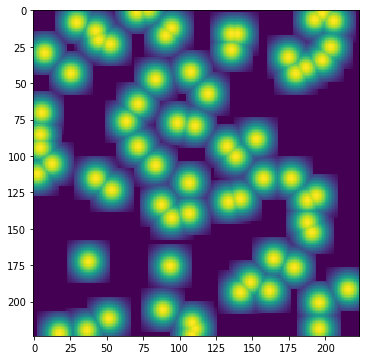

In [638]:
coords = np.random.rand(70, 2) * shape[0]
coords = coords.astype(np.int)
dummy_image = np.zeros((224, 224))
mask = generate_gaussian_mask(dummy_image, coords, 8, 30)
plt.figure(figsize=(6, 6))
plt.imshow(mask*255)

In [4]:
def gaussian_kernel(length=20, sigma=8):
    """Create gaussian kernel"""
    ax = np.linspace(-(length - 1) / 2., (length - 1) / 2., length)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sigma))
    return kernel / np.sum(kernel)


def rescale_min_max(values, nmin=0, nmax=1):
    """Rescale values to new nmin and nmax"""
    vmin, vmax = values.min(), values.max()
    scaled = (values - vmin)/(vmax - vmin)
    scaled = scaled * (nmax - nmin) + nmin
    return scaled


In [376]:
x = 3
type(x) == int

True

In [321]:
def gaussian_kernel(filter_size, sigma, mean):
    kx = cv2.getGaussianKernel(filter_size[0], sigma)
    ky = cv2.getGaussianKernel(filter_size[1], sigma)
    k = kx * np.transpose(ky)
    k *= (mean / np.max(k))
    return k

In [327]:
def generate_sparse_mask(pos, shape):
    """Generate sparse mask of given shape based on pos coordinates"""
    mask = np.zeros(shape, dtype=np.float32)
    for x, y in pos:
        x, y = int(round(x, 0)), int(round(y, 0))
        mask[x, y] = 1.0
    return mask


def generate_mask(pos, shape=(224, 224), kernel_size=16, sigma=None):
    """
    Generates a blurred mask given the ground truth positions and a radius
    as well as a blurring parameter.

    Args:
        pos: the ground truth positions
        shape: the image shape
        radius: the desired radius
        sigma: the stddev along x and y

    Returns:
        np.array: the blurred ground truth mask
    """

    mask = generate_sparse_mask(pos, shape)

    # Then apply dilation to transform center to ball
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    mask = cv2.dilate(mask, kernel, iterations=1)

    if sigma:
        mask = cv2.GaussianBlur(mask, ksize=(kernel_size+1, kernel_size+1), sigmaX=sigma, sigmaY=sigma)

    return mask, kernel

In [365]:
def add_kernel(img, k, x, y):
    """
    Add a kernel to an image
    :param img: (array) image with dimension (W, H) to add kernel on
    :param k:  (array) kernel with dimension (W, H)
    :param x: (int) x coordinate
    :param y: (int) y coordinate
    :return: image with added kernel k
    """

    kh, kw = k.shape
    h, w = img.shape
    dkh, dkw = kw // 2, kh // 2
    xstart, xend, ystart, yend = x - dkw, x + dkw, y - dkh, y + dkh

    if xstart < 0:
        k = k[abs(xstart):, :]
        xstart = 0
    if xend > w:
        xend = w
        k = k[:xend-xstart, :]
    if ystart < 0:
        k = k[:, abs(ystart):]
        ystart = 0
    if yend > h:
        yend = h
        k = k[:, :yend-ystart]

    img[xstart:xend, ystart:yend] = np.maximum(img[xstart:xend, ystart:yend], k)
    return img


def generate_rempfler_mask(img, pos, sigma=8, kernel_size=30):
    kernel = gaussian_kernel((kernel_size, kernel_size), sigma, 1)
    for x, y in pos:
        x, y = int(round(x, 0)), int(round(y, 0))
        img = add_kernel(img, kernel, x, y)
    return img

In [457]:
k_mask = generate_mask(coords, dummy_image.shape, sigma=8)[0]
r_mask = generate_rempfler_mask(dummy_image, coords, sigma=8)

In [ ]:
r_mask.reshape()

In [562]:
def draw_circles_on_image(image, *point_instances, colors=None):
    """
    Draw points on a given image with different options of coloring.

    :image:
    :points: Instances of points in [(x, y), ...] format.
    """

    if np.array(colors).any():
        new_colors = values_to_rgb(colors)
    else:
        new_colors = plt.get_cmap("Set1").colors
    new_colors = tuple(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), new_colors))

    gray_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    radius = 5
    thickness = -1

    for i, points in enumerate(point_instances):
        for j, p in enumerate(points):
            x, y = p
            color = new_colors[j] if np.array(colors).any() else new_colors[i]
            gray_image = cv2.circle(gray_image, (int(x), int(y)), radius, color, thickness)
            gray_image = cv2.circle(gray_image, (int(x), int(y)), radius, (0, 0, 0), 0)

    return gray_image

In [627]:
def crop_image_with_positions(img, pos, crop_shape):
    ch, cw = (crop_shape, crop_shape) if type(crop_shape) is int else crop_shape
    ih, iw = img.shape
    
    rows = iw // cw
    cols = ih // ch

    res = {
        "crop": [],
        "coordinates": []
    }
    
    ymin = 0
    xmax, ymax = cw, ch
    for col in range(cols):
        xmin = 0
        xmax = cw
        for row in range(rows):
            crop = img[ymin:ymax, xmin:xmax]

            # Get crop coordinates
            idx = np.where((pos[:, 0] <= ymax) & (pos[:, 0] >= ymin) & 
                          (pos[:, 1] <= xmax) & (pos[:, 1] >= xmin))     
            coords = pos[idx]
            x = coords[:, 1] - xmin
            y = coords[:, 0] - ymin
    
            res.get("crop").append(crop)
            res.get("coordinates").append(np.array(list(zip(x, y))))
            
            xmin += cw
            xmax += cw
        ymin += ch
        ymax += ch
            
    return res

In [628]:
x = np.arange(10)
y = np.arange(10)

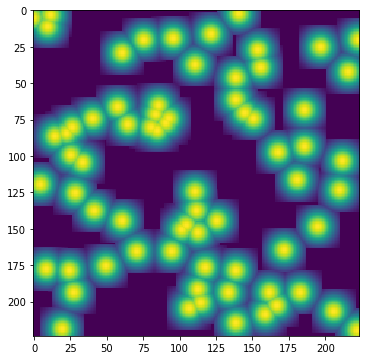

In [629]:
coords = np.random.rand(70, 2) * shape[0]
coords = coords.astype(np.int)
dummy_image = np.zeros((224, 224))
k_mask = generate_mask(coords, dummy_image.shape, sigma=8)[0]
r_mask = generate_rempfler_mask(dummy_image, coords, sigma=8)
plt.figure(figsize=(6, 6))
plt.imshow(r_mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


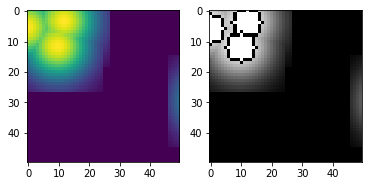

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


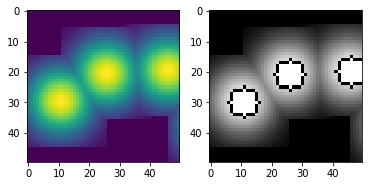

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


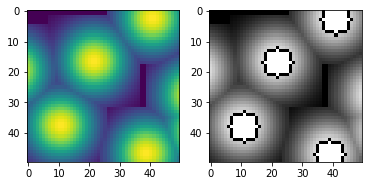

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


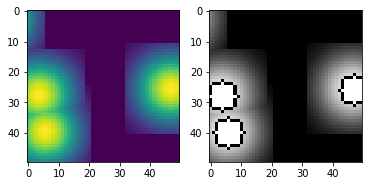

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


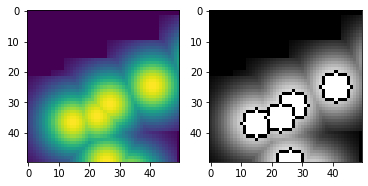

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


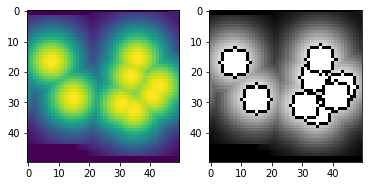

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


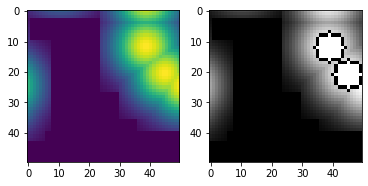

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


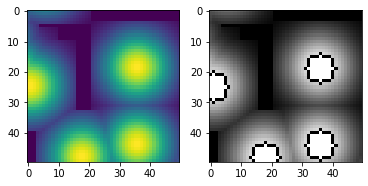

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


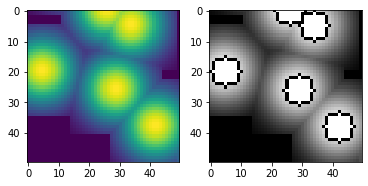

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


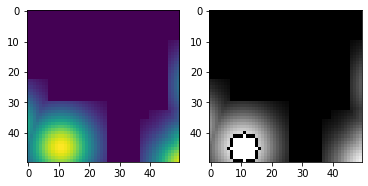

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


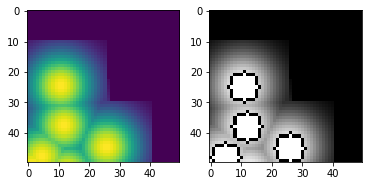

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


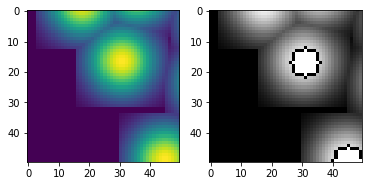

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


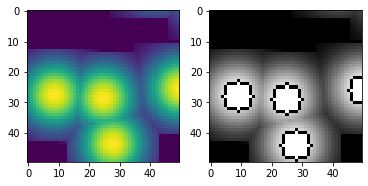

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


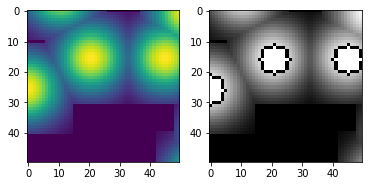

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


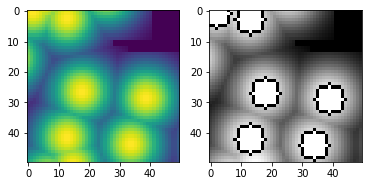

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


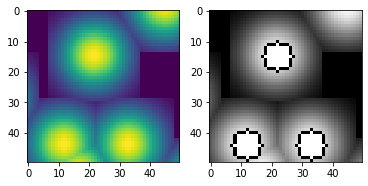

In [630]:
x = crop_image_with_positions(r_mask, coords, 50)
for crop, pos in zip(x.get("crop"), x.get("coordinates")):
    with_points = draw_circles_on_image(crop.astype(np.float32), pos)
    
    plt.subplot(121)
    plt.imshow(crop)
    plt.subplot(122)   
    plt.imshow(with_points)
    plt.show()

In [441]:
idx = np.where((coords[:, 0] < 30) & (coords[:, 0] > 0) & (coords[:, 1] < 150) & (coords[:, 1] > 100))


In [436]:
coords[idx]

array([[ 19, 110],
       [  5, 118],
       [  1, 109],
       [ 10, 128],
       [  6, 131],
       [ 17, 108],
       [ 14, 128],
       [ 20, 139],
       [ 18, 144],
       [  8, 116],
       [ 16, 137],
       [ 14, 127],
       [  1, 143],
       [ 18, 147],
       [ 16, 128],
       [ 21, 112],
       [ 11, 136],
       [  6, 140],
       [ 19, 127],
       [ 14, 133],
       [ 10, 124],
       [  2, 115],
       [ 13, 117],
       [ 28, 111],
       [ 10, 122],
       [ 13, 142],
       [  8, 143],
       [ 29, 107],
       [  8, 140],
       [ 21, 118],
       [ 20, 123],
       [ 13, 127],
       [  5, 109]])

In [409]:
coords[np.where(x == y)]

C:\Users\N.Jabareen\.conda\envs\tf_detection_api_cpu\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


array([], shape=(0, 2), dtype=int32)

In [399]:
coords[:, 0].min()

0

In [391]:
coords[:, 0]

array([123, 220,  19,  27, 114, 170,  99,  11,  94,  50, 129, 142, 184,
        67,  10,  29,  26,  82,  78,  97, 111,  35,  86,  24,  40,  11,
        19, 155,  33, 102,  91,  47, 175,   3,  50,  21,  79, 106,   5,
        33,  87,  49, 119,  27,   7,  25,  37, 166,   1,  63,  24,  48,
        52,  67,  61,  10,   6, 109,  86,  98,  78,  29, 135,  56,  57,
        79,  17, 111, 162,  14,  40,  53,  98,  79,  32,  17, 106, 126,
       131, 161,  45,  16,  83,   9,  20,  96,  53,  66, 117,  68, 179,
       154,  75, 134,  38,  18, 107, 156,   8,  34, 128,  34,  16,  29,
       192, 154,  31, 187,  24, 128,  93,  25,  14, 108, 210,  78, 168,
         4, 152, 141,  40, 111, 132,  45,   1,   4, 156,  17,  69,  60,
       147,  96,  59,  91, 127,  43,  45,  61,  73,   9,  42,  30,  23,
        49, 137,  18,  16, 107,  11,  71,  44,  20,   3,  61,  86, 149,
        30, 110,  37,  96,  17, 188,  89, 112,  30, 202, 198,  21,  11,
       133,  27,   0,  76,  15, 106, 133,  63,  44,  35,  77,  6

In [390]:
coords

array([[123, 197],
       [220, 223],
       [ 19,  42],
       [ 27,  52],
       [114, 154],
       [170, 223],
       [ 99, 164],
       [ 11, 179],
       [ 94, 128],
       [ 50,  71],
       [129, 172],
       [142, 214],
       [184, 206],
       [ 67, 135],
       [ 10, 154],
       [ 29,  87],
       [ 26, 169],
       [ 82, 195],
       [ 78, 154],
       [ 97, 177],
       [111, 142],
       [ 35, 204],
       [ 86, 104],
       [ 24,  71],
       [ 40,  74],
       [ 11, 202],
       [ 19, 110],
       [155, 175],
       [ 33,  63],
       [102, 220],
       [ 91, 165],
       [ 47,  81],
       [175, 202],
       [  3, 171],
       [ 50, 141],
       [ 21,  63],
       [ 79, 117],
       [106, 191],
       [  5, 118],
       [ 33, 116],
       [ 87, 133],
       [ 49,  80],
       [119, 194],
       [ 27, 169],
       [  7,  31],
       [ 25, 174],
       [ 37, 206],
       [166, 188],
       [  1, 109],
       [ 63, 119],
       [ 24, 212],
       [ 48, 115],
       [ 52,

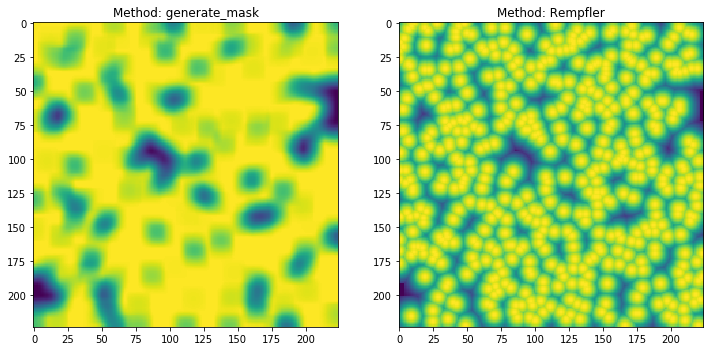

In [370]:
plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.title("Method: generate_mask")
plt.imshow(k_mask)
plt.subplot(122)
plt.title("Method: Rempfler")
plt.imshow(r_mask)
plt.show()

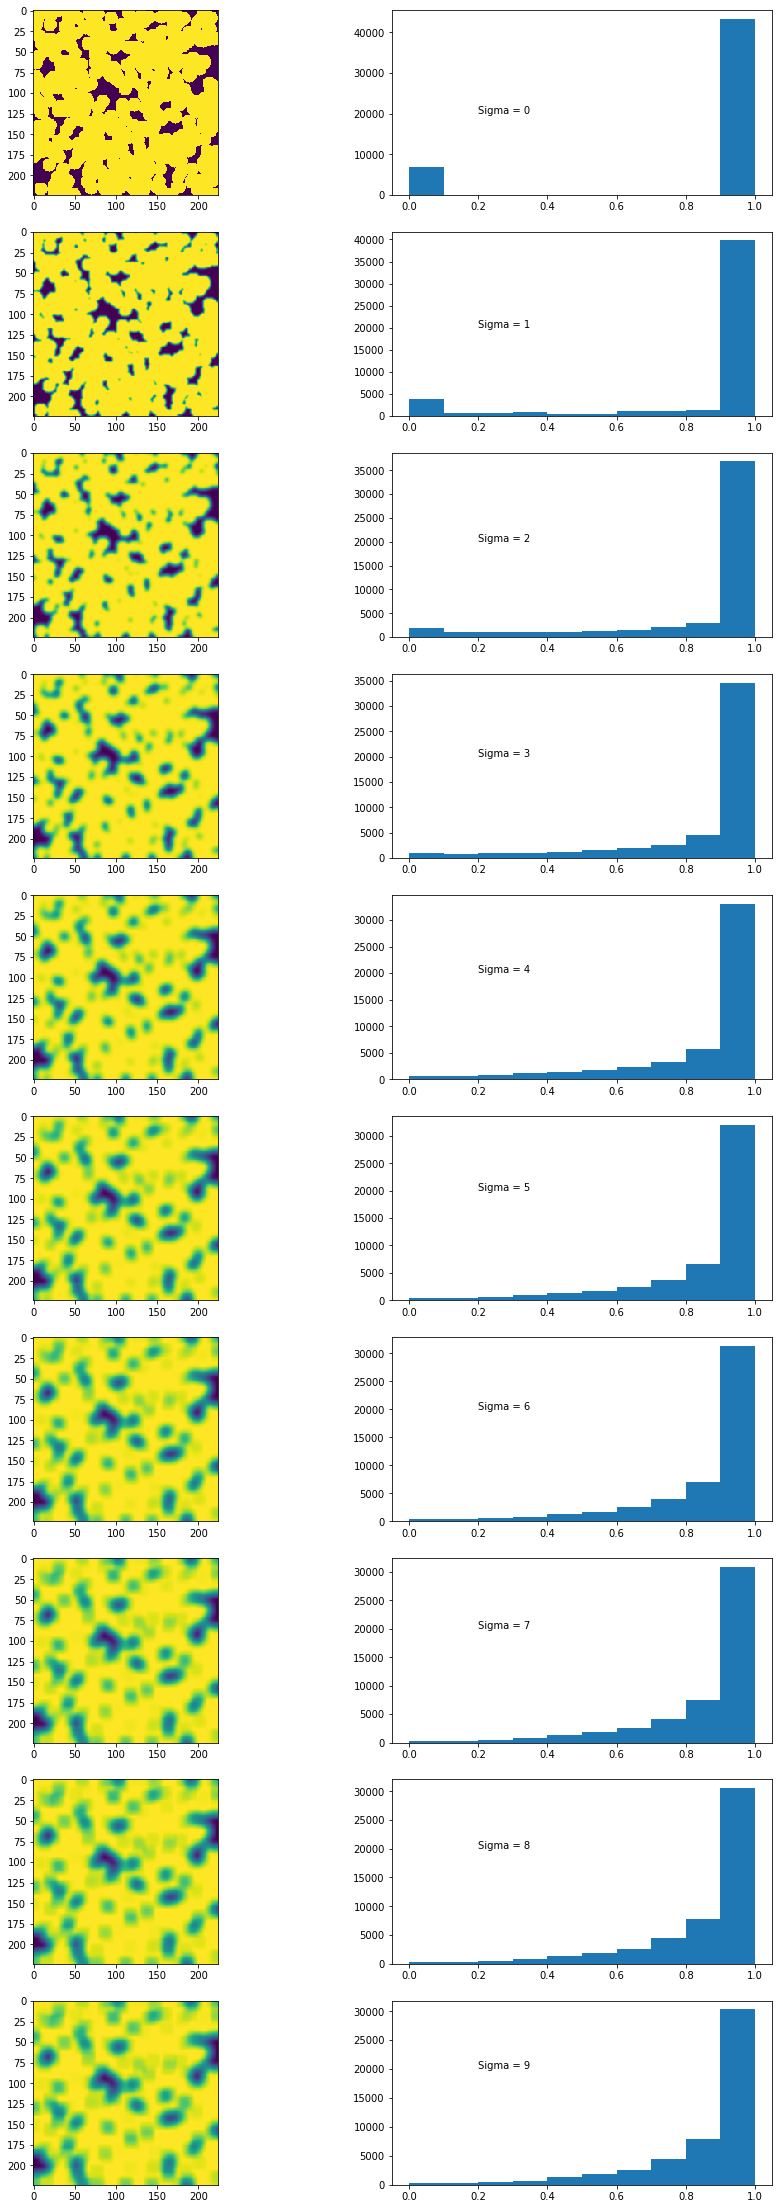

In [320]:
fig, axs = plt.subplots(10, 2)
fig.set_size_inches(15, 40)
for i in range(10):
    axs[i, 0].imshow(rescale_min_max(generate_mask(coords, sigma=i)[0]))
    axs[i, 1].hist(rescale_min_max(generate_mask(coords, sigma=i)[0]).flatten())
    axs[i, 1].text(0.2, 20000, f"Sigma = {i}")
plt.show()

In [284]:
shape = (224, 224)
example = np.zeros(shape)


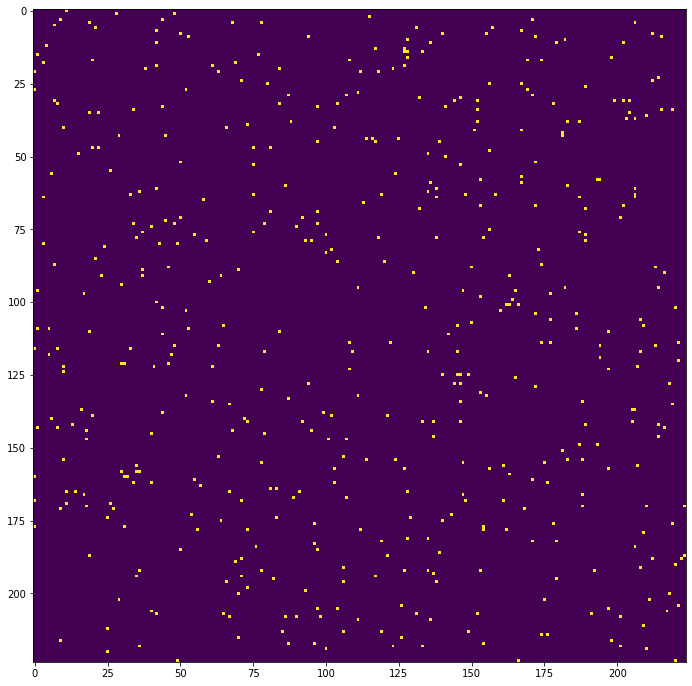

In [285]:
plt.figure(figsize=(12, 12))
plt.imshow(generate_sparse_mask(coords, shape))

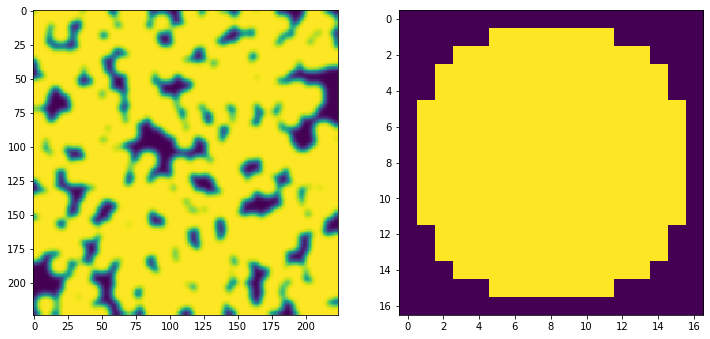

In [293]:
plt.figure(figsize=(12, 12))
mask, kernel = generate_mask(coords, shape, sigma=2)

plt.subplot(121)
plt.imshow(mask)
plt.subplot(122)
plt.imshow(kernel)
plt.show()

In [302]:
cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

array([[0, 0, 1, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [0, 0, 1, 0, 0]], dtype=uint8)